In [16]:
import os
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset

import numpy as np 
import pickle
import matplotlib.pyplot as plt
import time
import copy

from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/fcn')

In [17]:
X = pickle.load(open('../dataset/train/cross_subject_data_5_subjects.pickle', 'rb'))
y = X['train_y']

X = X['train_x'].astype(np.float32)

label_map = {'imagine_both_feet': 0, 'imagine_both_fist': 1, 'imagine_left_fist': 2, 'imagine_right_fist': 3}
y = np.vectorize(label_map.__getitem__)(y)

# Convert data to [n_samples, n_channels] -> [n_samples, seq_len, n_channels]

In [18]:
seq_len = 100
n_channels = 64

def reshape_data(X, y, seq_len):
    print('X original shape:', X.shape)
    print('y original shape:', y.shape)
    len_tail = X.shape[0] % seq_len
    X = X[:-len_tail].reshape(-1, seq_len, n_channels)
    y = y[:-len_tail].reshape(-1, seq_len)

    print('X conversion shape:', X.shape)
    print('y conversion shape:', y.shape)
    return X, y[:, -1]

X, y = reshape_data(X, y, seq_len)

X original shape: (295008, 64)
y original shape: (295008,)
X conversion shape: (2950, 100, 64)
y conversion shape: (2950, 100)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)
def print_class_dist(y):
    dist = {}

    labels = np.unique(y)
    for label in labels:
        dist[str(label)] = len(y[y == label]) / len(y)
    print(dist)
print_class_dist(y)
print_class_dist(y_train)
print_class_dist(y_test)

{'0': 0.24745762711864408, '1': 0.25254237288135595, '2': 0.25864406779661014, '3': 0.24135593220338983}
{'0': 0.24745762711864408, '1': 0.25254237288135595, '2': 0.2584745762711864, '3': 0.24152542372881355}
{'0': 0.24745762711864408, '1': 0.25254237288135595, '2': 0.2593220338983051, '3': 0.24067796610169492}


In [20]:
# Normalize
mean, std = X.mean(), X.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [21]:
X_train - 10

array([[[ -9.819402 ,  -9.806805 ,  -9.819402 , ...,  -9.580066 ,
          -9.617856 ,  -9.643049 ],
        [ -9.504486 ,  -9.605259 ,  -9.617856 , ...,  -9.5548725,
          -9.605259 ,  -9.630452 ],
        [ -9.428906 ,  -9.643049 ,  -9.655645 , ...,  -9.529679 ,
          -9.655645 ,  -9.592663 ],
        ...,
        [ -9.781611 ,  -9.706032 ,  -9.718629 , ...,  -9.731225 ,
          -9.680839 ,  -9.857191 ],
        [ -9.806805 ,  -9.794209 ,  -9.794209 , ...,  -9.655645 ,
          -9.617856 ,  -9.743822 ],
        [ -9.819402 ,  -9.668242 ,  -9.668242 , ...,  -9.643049 ,
          -9.56747  ,  -9.718629 ]],

       [[-10.222493 , -10.134316 , -10.134316 , ..., -10.373652 ,
         -10.550005 , -10.386249 ],
        [-10.348459 , -10.2602825, -10.222493 , ..., -10.348459 ,
         -10.512215 , -10.348459 ],
        [-10.487021 , -10.348459 , -10.27288  , ..., -10.209896 ,
         -10.398846 , -10.209896 ],
        ...,
        [ -9.731225 ,  -9.41631  ,  -9.5548725, ...,  

In [22]:
batch_size = 100
X_train, y_train = torch.tensor(X_train).to(device), torch.tensor(y_train).to(device)
X_test, y_test = torch.tensor(X_test).to(device), torch.tensor(y_test).to(device)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}
dataloaders = {'train': train_loader, 'val': test_loader}
class_names = list(label_map.keys())
print(class_names)

['imagine_both_feet', 'imagine_both_fist', 'imagine_left_fist', 'imagine_right_fist']


In [23]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            writer.add_scalar(f'{phase} loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase} accuracy', epoch_acc, epoch)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

In [24]:
input_size = 64
sequence_length = seq_len
hidden_size = 512
num_layers = 2
num_classes = 4
num_epochs = 100
batch_size = 100

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # x-> batch_size, seq, input_size
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.rnn(x, (h0, c0))
        # out: batch_size, seq_length, hidden_size
        # out: (N, 28, 128)
        out = out[:, -1, :]
        # out (N, 128)
        out = self.fc(out)
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

writer.add_graph(model, X_train)

model = train_model(model, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/99
----------
train Loss: 1.3921 Acc: 0.2653
val Loss: 1.3889 Acc: 0.2458

Epoch 1/99
----------
train Loss: 1.3795 Acc: 0.2758
val Loss: 1.3956 Acc: 0.2576

Epoch 2/99
----------
train Loss: 1.3708 Acc: 0.3008
val Loss: 1.3782 Acc: 0.2525

Epoch 3/99
----------
train Loss: 1.3601 Acc: 0.3051
val Loss: 1.3976 Acc: 0.2593

Epoch 4/99
----------
train Loss: 1.3515 Acc: 0.3237
val Loss: 1.3832 Acc: 0.2644

Epoch 5/99
----------
train Loss: 1.3423 Acc: 0.3220
val Loss: 1.3717 Acc: 0.2983

Epoch 6/99
----------
train Loss: 1.3245 Acc: 0.3504
val Loss: 1.3865 Acc: 0.2847

Epoch 7/99
----------
train Loss: 1.3113 Acc: 0.3564
val Loss: 1.4019 Acc: 0.2695

Epoch 8/99
----------
train Loss: 1.2818 Acc: 0.3669
val Loss: 1.4488 Acc: 0.2559

Epoch 9/99
----------
train Loss: 1.2661 Acc: 0.3758
val Loss: 1.3823 Acc: 0.3068

Epoch 10/99
----------
train Loss: 1.2525 Acc: 0.3949
val Loss: 1.3884 Acc: 0.3203

Epoch 11/99
----------
train Loss: 1.2315 Acc: 0.4144
val Loss: 1.4123 Acc: 0.2864

Ep

In [25]:
_, y_pred = torch.max(model(X_test), 1)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
cr = classification_report(y_test.cpu().numpy(), y_pred.cpu().numpy())
print(cr)

cm = confusion_matrix(y_test.cpu().numpy(), y_pred.cpu().numpy())
print(cm)

y_pred_ohe = np.zeros((y_pred.size(0), num_classes))
for i, j in enumerate(y_pred):
    y_pred_ohe[i, j] = 1

y_test_ohe = np.zeros((y_test.size(0), num_classes))
for i, j in enumerate(y_test):
    y_test_ohe[i, j] = 1
auroc = roc_auc_score(y_test_ohe, y_pred_ohe, multi_class='ovo')
writer.add_scalar('AUROC OvO', auroc)
print('AUROC ovo:', auroc)
auroc = roc_auc_score(y_test_ohe, y_pred_ohe, multi_class='ovr')
writer.add_scalar('AUROC OvR', auroc)
print('AUROC ovr:', auroc)

              precision    recall  f1-score   support

           0       0.32      0.28      0.30       146
           1       0.37      0.42      0.39       149
           2       0.35      0.35      0.35       153
           3       0.32      0.32      0.32       142

    accuracy                           0.34       590
   macro avg       0.34      0.34      0.34       590
weighted avg       0.34      0.34      0.34       590

[[41 44 31 30]
 [22 62 38 27]
 [29 31 54 39]
 [35 30 31 46]]
AUROC ovo: 0.562363317597656
AUROC ovr: 0.562363317597656


In [27]:
{str(v): k for k, v in label_map.items()}

{'0': 'imagine_both_feet',
 '1': 'imagine_both_fist',
 '2': 'imagine_left_fist',
 '3': 'imagine_right_fist'}

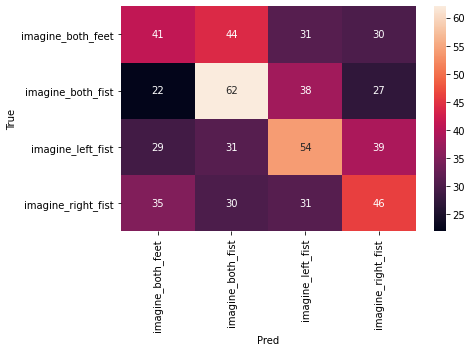

In [28]:
import seaborn as sns
import pandas as pd
import io

figure = plt.figure(figsize=(7, 5))
cm_df = pd.DataFrame(cm, columns=class_names, index=class_names)
sns.heatmap(cm_df, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Pred')
plt.tight_layout()
plt.savefig('runs/fcn/cm.png')
plt.show()

In [ ]:
print('Number of trainable parameters')
sum(p.numel() for p in model.parameters() if p.requires_grad)

Number of trainable parameters


3287044